# Análise de KPIs - Sistema de Energia
## Consumo Médio, Horas de Pico e Eficácia Tarifária

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('Bibliotecas carregadas!')

Bibliotecas carregadas!


## 1. Carregar Dados

In [2]:
# Carregar do banco de dados
conn = sqlite3.connect('../data/energia.db')

df_consumo = pd.read_sql_query('SELECT * FROM consumo', conn)
df_consumidores = pd.read_sql_query('SELECT * FROM consumidores', conn)
df_tarifas = pd.read_sql_query('SELECT * FROM tarifas', conn)
df_picos = pd.read_sql_query('SELECT * FROM picos', conn)

conn.close()

# Converter datas
df_consumo['data_hora'] = pd.to_datetime(df_consumo['data_hora'])
df_picos['data_hora'] = pd.to_datetime(df_picos['data_hora'])

print(f' Dados carregados: {len(df_consumo):,} registros de consumo')

 Dados carregados: 72,000 registros de consumo


## 2. KPI 1: Consumo Médio

 Consumo Médio por Tipo de Consumidor:

                consumo_kwh                    custo_total           
                       mean         sum  count        mean        sum
tipo_consumidor                                                      
Comercial             34.77   700888.99  20160       23.75  478860.69
Industrial           208.76  1352794.33   6480      142.68  924552.99
Residencial            9.31   422117.57  45360        6.36  288374.27


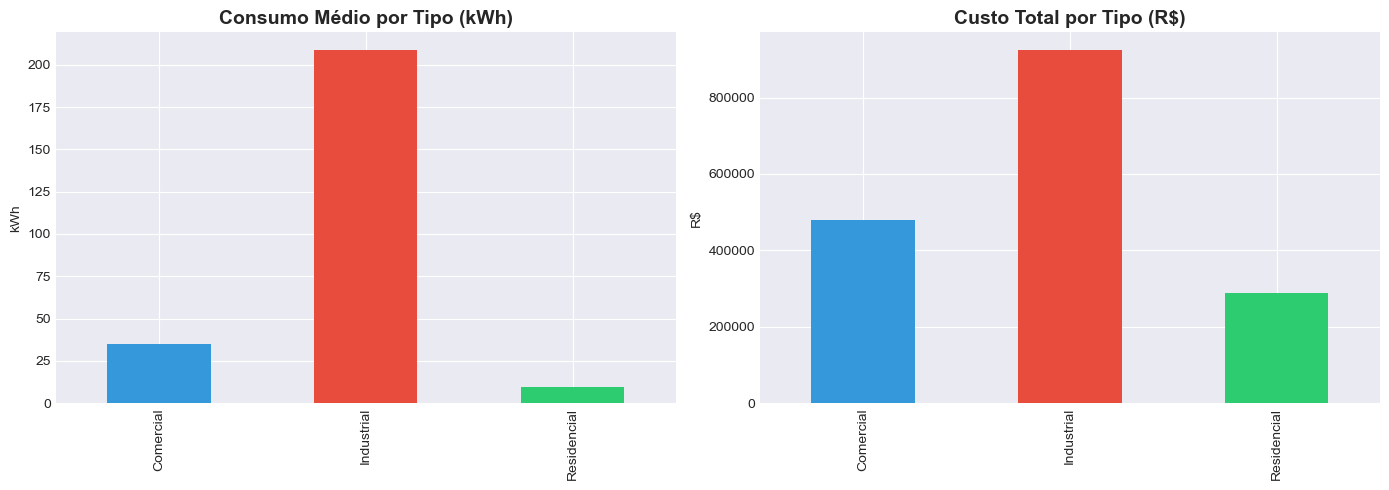

In [7]:
# Consumo médio por tipo de consumidor
df_merged = df_consumo.merge(df_consumidores, on='id_consumidor')

consumo_por_tipo = df_merged.groupby('tipo_consumidor').agg({
    'consumo_kwh': ['mean', 'sum', 'count'],
    'custo_total': ['mean', 'sum']
}).round(2)

print(' Consumo Médio por Tipo de Consumidor:\n')
print(consumo_por_tipo)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

consumo_medio = df_merged.groupby('tipo_consumidor')['consumo_kwh'].mean()
consumo_medio.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Consumo Médio por Tipo (kWh)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('kWh')
axes[0].set_xlabel('')

custo_total = df_merged.groupby('tipo_consumidor')['custo_total'].sum()
custo_total.plot(kind='bar', ax=axes[1], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Custo Total por Tipo (R$)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('R$')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

## 3. KPI 2: Horas de Pico

 Consumo por Horário:

   hora  consumo_kwh  custo_total
0     0     48010.44     21604.59
1     1     48371.90     21767.31
2     2     47928.44     21567.76
3     3     47347.63     21306.76
4     4     47836.97     21526.58
5     5     48521.65     21834.95
6     6     48148.90     21666.89
7     7    107333.17     69766.65
8     8    106644.38     69318.89
9     9    106978.67     69536.04


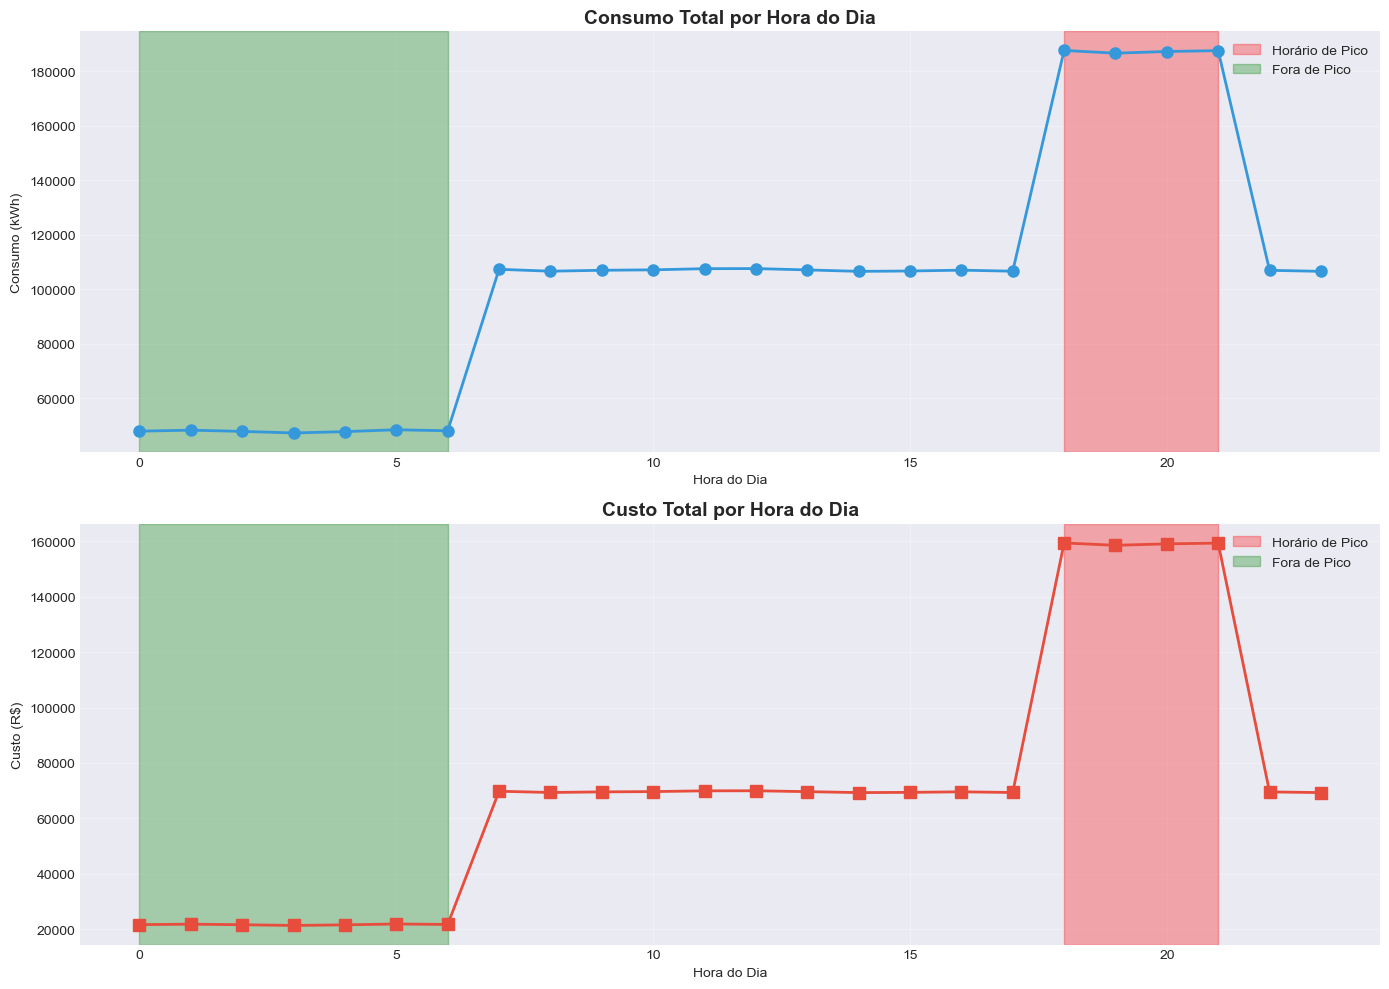

In [8]:
# Análise por hora do dia
df_consumo['hora'] = pd.to_datetime(df_consumo['data_hora']).dt.hour

consumo_por_hora = df_consumo.groupby('hora').agg({
    'consumo_kwh': 'sum',
    'custo_total': 'sum'
}).reset_index()

# Merge com tarifas para identificar períodos
df_consumo_tarifa = df_consumo.merge(df_tarifas, on='id_tarifa')

print(' Consumo por Horário:\n')
print(consumo_por_hora.head(10))

# Visualização
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Consumo por hora
axes[0].plot(consumo_por_hora['hora'], consumo_por_hora['consumo_kwh'], 
             marker='o', linewidth=2, markersize=8, color='#3498db')
axes[0].axvspan(18, 21, alpha=0.3, color='red', label='Horário de Pico')
axes[0].axvspan(0, 6, alpha=0.3, color='green', label='Fora de Pico')
axes[0].set_title('Consumo Total por Hora do Dia', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hora do Dia')
axes[0].set_ylabel('Consumo (kWh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Custo por hora
axes[1].plot(consumo_por_hora['hora'], consumo_por_hora['custo_total'], 
             marker='s', linewidth=2, markersize=8, color='#e74c3c')
axes[1].axvspan(18, 21, alpha=0.3, color='red', label='Horário de Pico')
axes[1].axvspan(0, 6, alpha=0.3, color='green', label='Fora de Pico')
axes[1].set_title('Custo Total por Hora do Dia', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hora do Dia')
axes[1].set_ylabel('Custo (R$)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. KPI 3: Eficácia Tarifária

 Consumo e Custo por Tipo de Tarifa:

    tipo_horario  consumo_kwh  custo_total  valor_kwh
0      Fora_Pico    336165.93    151274.84       0.45
1  Intermediario   1390877.62    904069.87       0.65
2           Pico    748757.34    636443.24       0.85

 ANÁLISE DE ECONOMIA POTENCIAL:
Custo Atual: R$ 1,691,787.95
Custo Otimizado (tudo fora de pico): R$ 1,114,110.40
Economia Potencial: R$ 577,677.55
Percentual de Economia: 34.1%


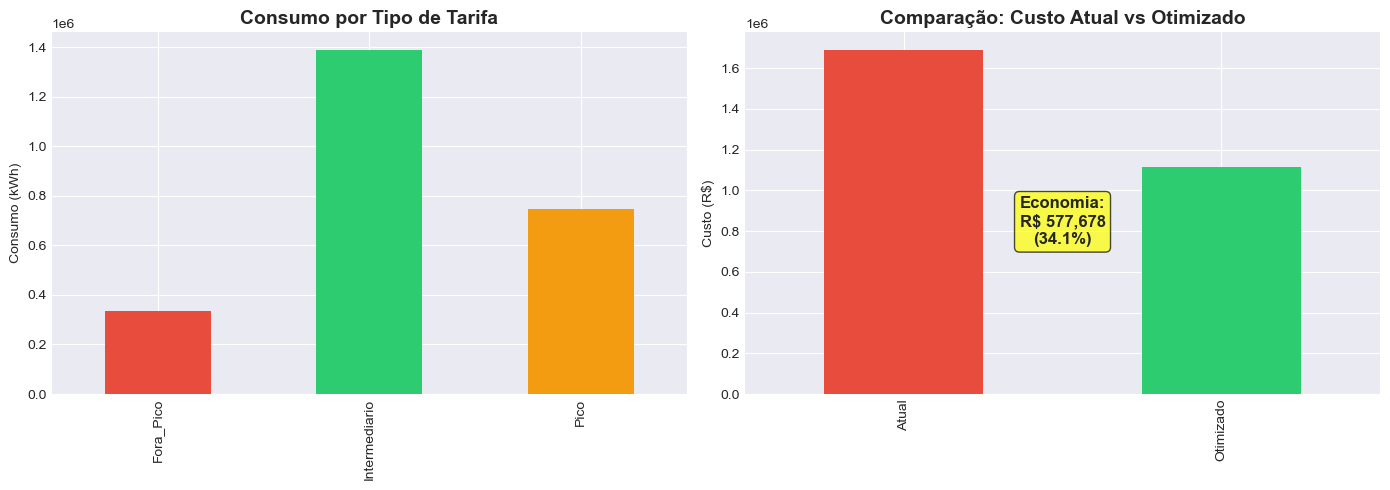

In [9]:
# Análise de eficácia tarifária
consumo_por_tarifa = df_consumo_tarifa.groupby('tipo_horario').agg({
    'consumo_kwh': 'sum',
    'custo_total': 'sum',
    'valor_kwh': 'first'
}).reset_index()

print(' Consumo e Custo por Tipo de Tarifa:\n')
print(consumo_por_tarifa)

# Calcular economia potencial
custo_atual = df_consumo['custo_total'].sum()
consumo_total = df_consumo['consumo_kwh'].sum()
tarifa_fora_pico = df_tarifas[df_tarifas['tipo_horario'] == 'Fora_Pico']['valor_kwh'].values[0]
custo_otimizado = consumo_total * tarifa_fora_pico
economia_potencial = custo_atual - custo_otimizado
percentual_economia = (economia_potencial / custo_atual) * 100

print(f'\n ANÁLISE DE ECONOMIA POTENCIAL:')
print(f'Custo Atual: R$ {custo_atual:,.2f}')
print(f'Custo Otimizado (tudo fora de pico): R$ {custo_otimizado:,.2f}')
print(f'Economia Potencial: R$ {economia_potencial:,.2f}')
print(f'Percentual de Economia: {percentual_economia:.1f}%')

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuição de consumo por tarifa
consumo_por_tarifa.plot(x='tipo_horario', y='consumo_kwh', kind='bar', 
                        ax=axes[0], color=['#e74c3c', '#2ecc71', '#f39c12'], legend=False)
axes[0].set_title('Consumo por Tipo de Tarifa', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Consumo (kWh)')
axes[0].set_xlabel('')

# Comparação de custos
custos = pd.DataFrame({
    'Cenário': ['Atual', 'Otimizado'],
    'Custo': [custo_atual, custo_otimizado]
})
custos.plot(x='Cenário', y='Custo', kind='bar', ax=axes[1], 
            color=['#e74c3c', '#2ecc71'], legend=False)
axes[1].set_title('Comparação: Custo Atual vs Otimizado', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Custo (R$)')
axes[1].set_xlabel('')

# Adicionar texto de economia
axes[1].text(0.5, custo_atual * 0.5, f'Economia:\nR$ {economia_potencial:,.0f}\n({percentual_economia:.1f}%)',
             ha='center', va='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 5. Top Consumidores com Maior Potencial de Economia

 Top 10 Consumidores com Maior Potencial de Economia:

         nome tipo_consumidor  consumo_kwh  economia_potencial
Consumidor_53      Industrial     61545.30           24618.120
Consumidor_51      Industrial     58108.96           23243.584
Consumidor_12      Industrial     52797.38           21118.952
Consumidor_34      Industrial     51354.67           20541.868
Consumidor_44      Industrial     45077.42           18030.968
Consumidor_35      Industrial     41758.91           16703.564
Consumidor_70      Industrial     40909.42           16363.768
 Consumidor_2      Industrial     28935.69           11574.276
Consumidor_56      Industrial     28860.09           11544.036
Consumidor_74       Comercial     10275.08            4110.032


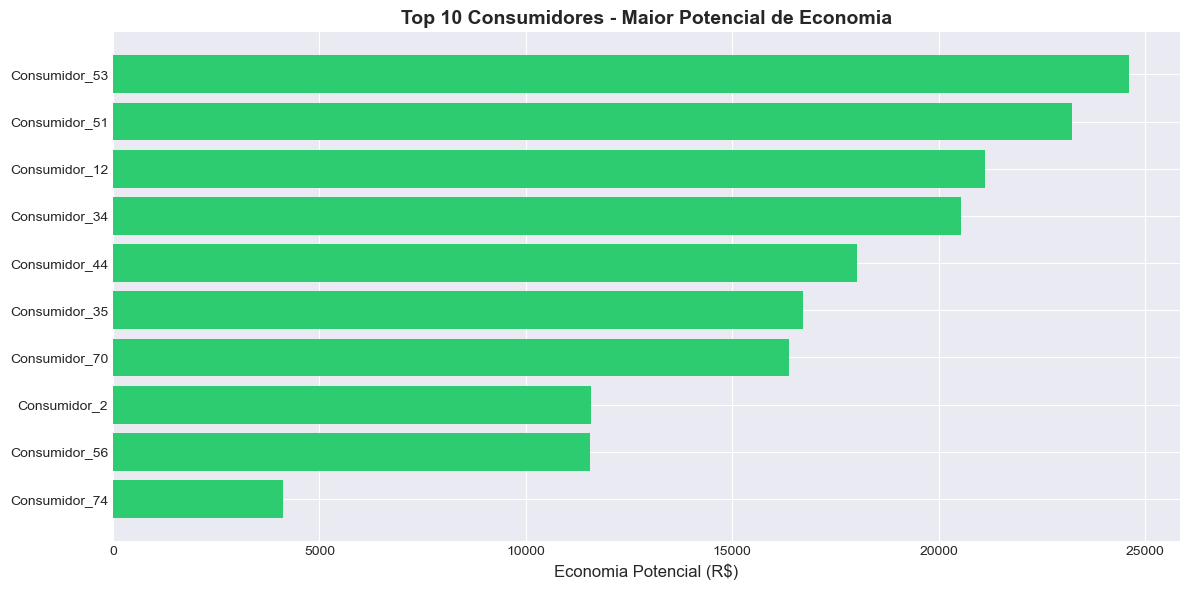

In [6]:
# Identificar consumidores com maior consumo em horário de pico
consumo_pico = df_consumo_tarifa[df_consumo_tarifa['tipo_horario'] == 'Pico']

top_consumidores = consumo_pico.groupby('id_consumidor').agg({
    'consumo_kwh': 'sum',
    'custo_total': 'sum'
}).reset_index()

# Calcular economia potencial individual
top_consumidores['economia_potencial'] = top_consumidores['consumo_kwh'] * (0.85 - 0.45)
top_consumidores = top_consumidores.sort_values('economia_potencial', ascending=False).head(10)

# Merge com dados do consumidor
top_consumidores = top_consumidores.merge(df_consumidores[['id_consumidor', 'nome', 'tipo_consumidor']], 
                                          on='id_consumidor')

print(' Top 10 Consumidores com Maior Potencial de Economia:\n')
print(top_consumidores[['nome', 'tipo_consumidor', 'consumo_kwh', 'economia_potencial']].to_string(index=False))

# Visualização
plt.figure(figsize=(12, 6))
plt.barh(top_consumidores['nome'], top_consumidores['economia_potencial'], color='#2ecc71')
plt.xlabel('Economia Potencial (R$)', fontsize=12)
plt.title('Top 10 Consumidores - Maior Potencial de Economia', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()